# Project 2 Ames Housing Prediction 

## Contents

- <a href='#background'>Background and Problem Statement</a>
- [Data Import & Cleaning](#Data-Import-and-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- <a href='#feature engineering'>Feature Engineering</a>
= <a href='#Model Fitting and Cross Validation'>Model Fitting and Cross Validation</a>
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

<a id='background'></a>
## Background and Problem Statement

The goal of this analysis is to predict housing prices in Ames, Iowa using extensive [data](../datasets/train.csv) about various features of the house (79 features about the size, quality, amenities etc.). A detailed description of the dataset can be found in the [data description](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)

The house prices are predicted using a Linear Regression model and the model was tuned to minimize root mean square error on the available data.

Problem Statement: As the observed house prices have a log normal distribution (jump to visualizations of this distribution in the [EDA section](#Exploratory-Data-Analysis)), in addition to predicting the house prices for the 878 houses in the [test data](../datasets/test.csv), this analysis aims to determine if predicting log prices instead of prices gives a better fitting model and to quanify the lift in $R^{2}$ if this is indeed the case.

## Functions

This sections contains some plotting and preprocessing functions used in the notebook

In [37]:
def numerical_to_categorical_and_plot(category, target, df):
    '''
bins numerical columns into 10 bins with equal # observations and 
plots mean of target column for each bin vs bin average
TODO: 
include a plan to deal with missing values when binning the category column. 
add the average number of observations in each bin to the graphs
Didn't look up pd.qcut does with missing values

'''
    
    df_copy = df.copy()
    df_copy[f'{category}_bins'] = pd.qcut(df_copy[category],10, duplicates = 'drop')
    result_df = df_copy.groupby(f'{category}_bins').agg({target:['mean', 'count']})
    result_df[f'{category}_bin_average']=[round(a.mid) for a in result_df.index]
    result_df.columns = result_df.columns.to_flat_index()
    result_df.columns = [x[0]  if x[1] == '' else x[0]+'_'+x[1] for x in result_df.columns]
    fig, ax = plt.subplots()
    sns.lineplot(x = f'{category}_bin_average', y = f'{target}_mean' , data = result_df,         
                    ax = ax, color = '#0b5394');   
    return result_df


def plot_bar_line(category, target, df, sort = False):
    
    
    '''
    creates the following two plots on a single figure with two y-axes 
    for category and target columns of a df
    1. left y-axis: bar graph mean of target per category
    2. right y-axes: line plot of # of observations in each value of category in df
    
    If sort = True, the bars are ordered in descending values of the mean of target

   '''
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    if sort:

        df1 = (
            df.groupby([category])[target].mean()
            .to_frame().reset_index().sort_values(by = target, ascending = False)
        )
    else:
        df1 = (
            df.groupby([category])[target].mean()
            .to_frame().reset_index()
        )
        
    
    df2 =(df[category].value_counts(sort = False)
          .rename_axis(category).to_frame('Counts').reset_index()
    )
 
    
    
    df = df1.merge(df2, how ='left', on = category)
        
    df[category] = df[category].astype(str)

    sns.barplot(x = category, y = target, data = df, ci = False, 
                ax = ax1, color = '#0b5394')
    sns.lineplot(x = category , y = 'Counts', data = df, 
                 ax = ax2, color = 'red',marker = 'o'  );

    ax1.set_xlabel(category, color = 'black')
    ax1.set_ylabel(f'{target}_mean',color = '#0b5394')
    ax2.set_ylabel('# Observations',color = 'red');
    


<a id='Data-Import-and-Cleaning'></a>
## Data Import and Cleaning


In [1]:
# Imports:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

%matplotlib inline

#display all output form a cell not just the last (the options are 'all', 'none', 'last' and 'last_expr'.)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


# seaborn plot styles

sns.set_style("dark")
sns.set_palette("deep")
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["axes.titlesize"] = 20
myblue = '#0b5394'

source: [display all output from a jupyter cell](https://stackoverflow.com/questions/36786722/how-to-display-full-output-in-jupyter-not-only-last-result)

In [3]:
path_train = '../datasets/train.csv'
path_test = '../datasets/test.csv'

#read in training data

ames_df = pd.read_csv(path_train)
test_df = pd.read_csv(path_test)

ames_df.shape
test_df.shape

(2051, 81)

(878, 80)

### Treating Missing Values


In [12]:
null_counts = ames_df.isnull().sum() 

#list of column names with nulls
columns_with_nulls = null_counts[null_counts>0].index 

print('columns with null values and the number of null values are:')
null_counts[columns_with_nulls]

#dropping columns in which more than 40% of the observations are missing
cols_to_drop = [col for col in columns_with_nulls if null_counts[col] > 0.4*ames_df.shape[0]]
print(f'#columns being dropped: {len(cols_to_drop)}')

# the rest of the columns with missing values to be treated with some imputing strategy
cols_to_impute = [col for col in columns_with_nulls if null_counts[col] <= 0.4*ames_df.shape[0]]
print(f'#columns to impute: {len(cols_to_impute)}')
ames_df[cols_to_impute].describe()

columns with null values and the number of null values are:


Lot Frontage       330
Alley             1911
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Qual           55
Bsmt Cond           55
Bsmt Exposure       58
BsmtFin Type 1      55
BsmtFin SF 1         1
BsmtFin Type 2      56
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Bsmt Full Bath       2
Bsmt Half Bath       2
Fireplace Qu      1000
Garage Type        113
Garage Yr Blt      114
Garage Finish      114
Garage Cars          1
Garage Area          1
Garage Qual        114
Garage Cond        114
Pool QC           2042
Fence             1651
Misc Feature      1986
dtype: int64

#columns being dropped: 5
#columns to impute: 21


,Lot Frontage,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath,Garage Yr Blt,Garage Cars,Garage Area
count,1721.000000,2029.000000,2050.000000,2050.000000,2050.000000,2050.000000,2049.000000,2049.000000,1937.000000,2050.000000,2050.000000
mean,69.055200,99.695909,442.300488,47.959024,567.728293,1057.987805,0.427526,0.063446,1978.707796,1.776585,473.671707
std,23.260653,174.963129,461.204124,165.000901,444.954786,449.410704,0.522673,0.251705,25.441094,0.764537,215.934561
min,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1895.000000,0.000000,0.000000
25%,58.000000,0.000000,0.000000,0.000000,220.000000,793.000000,0.000000,0.000000,1961.000000,1.000000,319.000000
50%,68.000000,0.000000,368.000000,0.000000,474.500000,994.500000,0.000000,0.000000,1980.000000,2.000000,480.000000
75%,80.000000,161.000000,733.750000,0.000000,811.000000,1318.750000,1.000000,0.000000,2002.000000,2.000000,576.000000
max,313.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,3.000000,2.000000,2207.000000,5.000000,1418.000000


The following steps were taken to treat missing values:
- 5 columns had more than 40\% of values missing. These columns have not been included in the analysis
- In the rest of the 21 columns with missing values, the missing values were replcaed with the mode of the column for categorical and discrete numerical columns and with the mean of the column for continuous numerical variables

In [10]:
# creating lists of various kinds of features 

cat_columns = ames_df.select_dtypes(object).columns.to_list()

discrete_columns = ['MS SubClass', 'Overall Qual','Overall Cond', 'Year Built', 'Year Remod/Add', 
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath',
       'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces',
       'Garage Yr Blt', 'Garage Cars',  'Misc Val', 'Mo Sold', 'Yr Sold']
continuous_columns = ['Lot Frontage', 'Lot Area', 'Mas Vnr Area',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area','Garage Area', 'Wood Deck SF',
       'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
       'Pool Area']
ames_df[continuous_columns].describe(percentiles = [0.01,0.1,0.25,0.5, 0.6, 0.75,0.9,0.99])
ames_df[discrete_columns].describe(percentiles = [0.01,0.1,0.25,0.5, 0.6, 0.75,0.9,0.99])

# checking that the above feature lists are correct
assert(ames_df.shape[1] == len(cat_columns)+len(discrete_columns)+len(continuous_columns) + len(['Id', 'PID', 'SalePrice']))

# drop columns with more than 40% missing values
df_no_nulls = ames_df.drop(columns = cols_to_drop)


# imputing missing values in the rest of the columns with nulls

imputed_df = df_no_nulls.copy()

for col in cols_to_impute:
#replacing null values in categorical and discrete numerical columns with the mode of the column
    if col in cat_columns + discrete_columns:
        imputed_df[col] = imputed_df[col].fillna(imputed_df[col].mode()[0])
#replacing the null values in continuous numerical columns with mean of the column    
    else:
        imputed_df[col] = imputed_df[col].fillna(imputed_df[col].mean())
        
imputed_df.dtypes
imputed_df.isnull().sum()

,Lot Frontage,Lot Area,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area
count,1721.000000,2051.000000,2029.000000,2050.000000,2050.000000,2050.000000,2050.000000,2051.000000,2051.000000,2051.000000,2051.000000,2050.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,69.055200,10065.208191,99.695909,442.300488,47.959024,567.728293,1057.987805,1164.488055,329.329108,5.512921,1499.330083,473.671707,93.833740,47.556802,22.571916,2.591419,16.511458,2.397855
std,23.260653,6742.488909,174.963129,461.204124,165.000901,444.954786,449.410704,396.446923,425.671046,51.068870,500.447829,215.934561,128.549416,66.747241,59.845110,25.229615,57.374204,37.782570
min,21.000000,1300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1%,21.000000,1680.000000,0.000000,0.000000,0.000000,0.000000,0.000000,511.000000,0.000000,0.000000,682.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10%,43.000000,5000.000000,0.000000,0.000000,0.000000,59.800000,600.000000,745.000000,0.000000,0.000000,935.000000,240.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,58.000000,7500.000000,0.000000,0.000000,0.000000,220.000000,793.000000,879.500000,0.000000,0.000000,1129.000000,319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,68.000000,9430.000000,0.000000,368.000000,0.000000,474.500000,994.500000,1093.000000,0.000000,0.000000,1444.000000,480.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000
60%,73.000000,10140.000000,1.000000,516.000000,0.000000,604.400000,1094.000000,1196.000000,396.000000,0.000000,1560.000000,516.000000,100.000000,40.000000,0.000000,0.000000,0.000000,0.000000
75%,80.000000,11513.500000,161.000000,733.750000,0.000000,811.000000,1318.750000,1405.000000,692.500000,0.000000,1728.500000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000


,MS SubClass,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Misc Val,Mo Sold,Yr Sold
count,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2049.000000,2049.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,1937.000000,2050.000000,2051.000000,2051.000000,2051.000000
mean,57.008776,6.112140,5.562165,1971.708922,1984.190151,0.427526,0.063446,1.577279,0.371039,2.843491,1.042906,6.435885,0.590931,1978.707796,1.776585,51.574354,6.219893,2007.775719
std,42.824223,1.426271,1.104497,30.177889,21.036250,0.522673,0.251705,0.549279,0.501043,0.826618,0.209790,1.560225,0.638516,25.441094,0.764537,573.393985,2.744736,1.312014
min,20.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,1.000000,2006.000000
1%,20.000000,3.000000,3.000000,1900.000000,1950.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,4.000000,0.000000,1916.000000,0.000000,0.000000,1.000000,2006.000000
10%,20.000000,5.000000,5.000000,1925.000000,1950.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1943.800000,1.000000,0.000000,3.000000,2006.000000
25%,20.000000,5.000000,5.000000,1953.500000,1964.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,0.000000,4.000000,2007.000000
50%,50.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,0.000000,6.000000,2008.000000
60%,60.000000,6.000000,5.000000,1987.000000,1998.000000,1.000000,0.000000,2.000000,0.000000,3.000000,1.000000,7.000000,1.000000,1993.000000,2.000000,0.000000,7.000000,2008.000000
75%,70.000000,7.000000,6.000000,2001.000000,2004.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,0.000000,8.000000,2009.000000


Id                   int64
PID                  int64
MS SubClass          int64
MS Zoning           object
Lot Frontage       float64
Lot Area             int64
Street              object
Lot Shape           object
Land Contour        object
Utilities           object
Lot Config          object
Land Slope          object
Neighborhood        object
Condition 1         object
Condition 2         object
Bldg Type           object
House Style         object
Overall Qual         int64
Overall Cond         int64
Year Built           int64
Year Remod/Add       int64
Roof Style          object
Roof Matl           object
Exterior 1st        object
Exterior 2nd        object
Mas Vnr Type        object
Mas Vnr Area       float64
Exter Qual          object
Exter Cond          object
Foundation          object
Bsmt Qual           object
Bsmt Cond           object
Bsmt Exposure       object
BsmtFin Type 1      object
BsmtFin SF 1       float64
BsmtFin Type 2      object
BsmtFin SF 2       float64
B

Id                 0
PID                0
MS SubClass        0
MS Zoning          0
Lot Frontage       0
Lot Area           0
Street             0
Lot Shape          0
Land Contour       0
Utilities          0
Lot Config         0
Land Slope         0
Neighborhood       0
Condition 1        0
Condition 2        0
Bldg Type          0
House Style        0
Overall Qual       0
Overall Cond       0
Year Built         0
Year Remod/Add     0
Roof Style         0
Roof Matl          0
Exterior 1st       0
Exterior 2nd       0
Mas Vnr Type       0
Mas Vnr Area       0
Exter Qual         0
Exter Cond         0
Foundation         0
Bsmt Qual          0
Bsmt Cond          0
Bsmt Exposure      0
BsmtFin Type 1     0
BsmtFin SF 1       0
BsmtFin Type 2     0
BsmtFin SF 2       0
Bsmt Unf SF        0
Total Bsmt SF      0
Heating            0
Heating QC         0
Central Air        0
Electrical         0
1st Flr SF         0
2nd Flr SF         0
Low Qual Fin SF    0
Gr Liv Area        0
Bsmt Full Bat

<a id='Exploratory-Data-Analysis'></a>
## Exploratory Data Analysis

### Investigating the target variable

The distribution of the SalePrice is log normal - distribution has high density around mean price and a long tail with few houses selling at high prices.

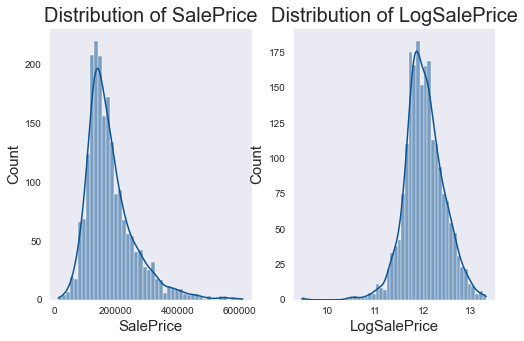

In [32]:
# Visualizing the distribution of the target variable = 'SalePrice'
fig, ax = plt.subplots(1,2,figsize = (8,5))
sns.histplot(x = imputed_df['SalePrice'], color = myblue, kde = True, ax = ax[0])
ax[0].set_title('Distribution of SalePrice');
sns.histplot(x = np.log(imputed_df['SalePrice']), color = myblue, kde = True, ax = ax[1])
ax[1].set_title('Distribution of LogSalePrice');
ax[1].set_xlabel('LogSalePrice');

In [33]:
#Looking at the correlation of all columns with SalePrice
corrs = ames_df.corr()[['SalePrice']]
corrs.sort_values(by = 'SalePrice', ascending = False)

,SalePrice
SalePrice,1.000000
Overall Qual,0.800207
Gr Liv Area,0.697038
Garage Area,0.650270
Garage Cars,0.648220
Total Bsmt SF,0.628925
1st Flr SF,0.618486
Year Built,0.571849
Year Remod/Add,0.550370
Full Bath,0.537969


### Investigating some of the numerical columns 

In this section, we explore the distributions of some of the numerical columns with hiogh correlations with the SalePrice
- Overall Condition and Overall Quality

**'Overall Cond' and 'Overall Qual'**

- Prices increase with 'Overall Qual' as expected
- There is negative correlation with 'Overall Cond' which is counterintuitive. Hence, not using 'Overall Cond' in the model

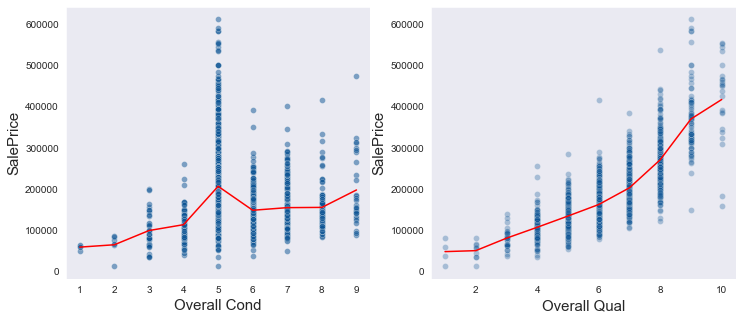

In [36]:
fig, ax = plt.subplots(1,2, figsize = (12,5));
sns.scatterplot(x = 'Overall Cond', y = 'SalePrice', data = imputed_df, ax = ax[0], color = myblue, alpha = 0.5);
sns.scatterplot(x = 'Overall Qual', y = 'SalePrice', data = imputed_df, ax = ax[1], color = myblue, alpha = 0.3);
sns.lineplot(x = 'Overall Qual', y = 'SalePrice', data = imputed_df.groupby('Overall Qual').mean(), 
             ax = ax[1], color = 'red');
sns.lineplot(x = 'Overall Cond', y = 'SalePrice', data = imputed_df.groupby('Overall Cond').mean(), 
             ax = ax[0], color = 'red');

**Garage Area and Garage Cars**

- As they are highly correlated to each other (corr = 0.89) and to SalePrice, only one of these variables will be used in the model

,Garage Area,Garage Cars
count,2051.000000,2051.000000
mean,473.671707,1.776694
std,215.881887,0.764367
min,0.000000,0.000000
25%,319.000000,1.000000
50%,480.000000,2.000000
75%,576.000000,2.000000
max,1418.000000,5.000000


SalePrice      
                      mean count
Garage Cars                     
0.0          105669.150442   113
1.0          126824.591603   524
2.0          184096.742304  1137
3.0          309382.745247   263
4.0          229653.846154    13
5.0          126500.000000     1

,Garage Area,Garage Cars,SalePrice
Garage Area,1.000000,0.893162,0.650246
Garage Cars,0.893162,1.000000,0.648128
SalePrice,0.650246,0.648128,1.000000


<AxesSubplot:xlabel='Garage Area', ylabel='SalePrice'>

,SalePrice_mean,SalePrice_count,Garage Area_bin_average
Garage Area_bins,,,
"(-0.001, 240.0]",115762.787234,235,120
"(240.0, 294.0]",123945.715084,179,267
"(294.0, 384.0]",132218.788732,213,339
"(384.0, 440.0]",164881.342742,248,412
"(440.0, 480.0]",176066.212291,179,460
"(480.0, 516.0]",184602.822222,180,498
"(516.0, 564.0]",197041.094340,212,540
"(564.0, 621.0]",191494.974490,196,592
"(621.0, 760.0]",239993.514706,204,690


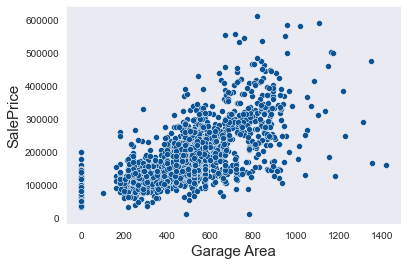

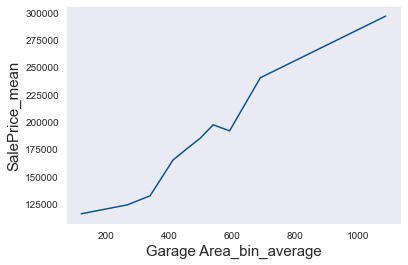

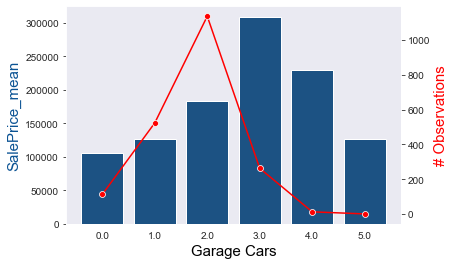

In [46]:
#Summary statistics
imputed_df[['Garage Area', 'Garage Cars']].describe()
imputed_df.groupby(['Garage Cars'])[['SalePrice']].agg(['mean','count'])

#correlations
imputed_df[['Garage Area','Garage Cars', 'SalePrice']].corr()

#plots
sns.scatterplot(data = imputed_df, x = 'Garage Area', y = 'SalePrice', color = myblue)
numerical_to_categorical_and_plot('Garage Area', 'SalePrice', imputed_df)
plot_bar_line('Garage Cars', 'SalePrice', imputed_df)




**Investigating Gr Liv Area, 1st Flr SF and 2nd Flr SF**

- They are highly correlated to each other (corr = 0.56). 
- Using only GR Liv Area as-is in the model which has a slightly higher correaltion (0.70 vs 0.62) with SalePrice



In [47]:
assert(imputed_df['Gr Liv Area'] == imputed_df['1st Flr SF'] + imputed_df['2nd Flr SF'])

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().